# Fitting the model

## Data Preprocessing

In [1]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn.metrics import roc_curve, confusion_matrix, accuracy_score, recall_score, precision_score

from sklearn.linear_model import LogisticRegression

# Set random seed 
RSEED = 42
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('data/data_clean.csv', index_col = 0)
df.head()

,backers_count,country,id,name,staff_pick,state,usd_pledged,usd_type,yr_launched,mo_launched,...,main_category,subcategory,city,region,city_type,creator_id,creator_num_projects,words_blurb,polarity_blurb,subjectivity_blurb
0,21,US,287514992,New Final Round Album,0,1,802.00000,international,2013,12,...,Music,Rock,Chicago,IL,Town,1495925645,1,26,0.178788,0.518182
1,97,US,385129759,Princess Pals Enamel Pin Series,0,1,2259.00000,international,2019,2,...,Art,Mixed Media,Sacramento,CA,Town,1175589980,4,9,0.625000,1.000000
2,88,US,681033598,Their Life Through Their Lens-the Amish and Me...,1,1,29638.00000,international,2016,11,...,Photography,Photobooks,Columbus,OH,Town,1196856269,2,25,0.225000,0.366667
3,193,IT,1031782682,WAO: THE ECO EFFECT SHOES,0,1,49075.15252,international,2018,10,...,Fashion,Footwear,Venice,Veneto,Town,1569700626,2,13,0.000000,0.100000
4,20,US,904085819,Apple Watch Development Course,0,0,549.00000,domestic,2015,3,...,Technology,Software,Redmond,WA,Town,1870845385,1,22,0.156250,0.400000


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 184113 entries, 0 to 184112
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   backers_count         184113 non-null  int64  
 1   country               184113 non-null  object 
 2   id                    184113 non-null  int64  
 3   name                  184113 non-null  object 
 4   staff_pick            184113 non-null  int64  
 5   state                 184113 non-null  int64  
 6   usd_pledged           184113 non-null  float64
 7   usd_type              184113 non-null  object 
 8   yr_launched           184113 non-null  int64  
 9   mo_launched           184113 non-null  int64  
 10  wd_launched           184113 non-null  int64  
 11  yr_deadline           184113 non-null  int64  
 12  mo_deadline           184113 non-null  int64  
 13  wd_deadline           184113 non-null  int64  
 14  founding_phase        184113 non-null  int64  
 15  

Let us delete all the variables that are not going to be useful in our model:
+ **"id", "creator_id", "name"**: 
+ **"disable_communication", "is starrable"**: only False
+ **"city", "region"**: these two variables will create too many columns in the One Hot encoding process. We keep "country"
+ **"yr_deadline","mo_deadline", "wd_deadline"**: these variables are hihgly correlated with the launching date and "funding_phase"

In [4]:
df.drop(['id', 'name', 'yr_deadline',"mo_deadline", "wd_deadline","city", "region","subcategory"], axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 184113 entries, 0 to 184112
Data columns (total 19 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   backers_count         184113 non-null  int64  
 1   country               184113 non-null  object 
 2   staff_pick            184113 non-null  int64  
 3   state                 184113 non-null  int64  
 4   usd_pledged           184113 non-null  float64
 5   usd_type              184113 non-null  object 
 6   yr_launched           184113 non-null  int64  
 7   mo_launched           184113 non-null  int64  
 8   wd_launched           184113 non-null  int64  
 9   founding_phase        184113 non-null  int64  
 10  phase_before          184113 non-null  int64  
 11  goal_usd              184113 non-null  float64
 12  main_category         184113 non-null  object 
 13  city_type             184113 non-null  object 
 14  creator_id            184113 non-null  int64  
 15  

In [5]:
cat_features = list(df.columns[df.dtypes==object])

num_features = list(df.columns[df.dtypes!=object])

num_features.remove('usd_pledged')
num_features.remove("backers_count")
num_features.remove("state")

In [6]:
# Define predictors and target variable

X = df.drop(['usd_pledged', "backers_count", "state"], axis=1)
y = df['state']

print(f"We have {X.shape[0]} observations in our dataset and {X.shape[1]} features")
print(f"Our target vector has also {y.shape[0]} values")

We have 184113 observations in our dataset and 16 features
Our target vector has also 184113 values


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RSEED)

## First model

In [8]:
num_pipeline = Pipeline([
    ('std_scaler', StandardScaler())
])

# Pipeline for categorical features 
cat_pipeline = Pipeline([
    ('imputer_cat', SimpleImputer(strategy='constant', fill_value='missing')),
    ('1hot', OneHotEncoder(handle_unknown='ignore'))
])

In [9]:
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])

In [10]:
pipe_logreg = Pipeline([
    ('preprocessor', preprocessor),
    ('logreg', LogisticRegression(max_iter=1000))
])

In [11]:
y_train_predicted = cross_val_predict(pipe_logreg, X_train, y_train, cv=5)

In [12]:
def print_scores(y_true, y_predicted):
# This function prints out a 

    print('Cross validation scores:')
    print('-------------------------')
    print("Accuracy: {:.2f}".format(accuracy_score(y_true, y_predicted)))
    print("Recall: {:.2f}".format(recall_score(y_true, y_predicted)))
    print("Precision: {:.2f}".format(precision_score(y_true, y_predicted)))

    cm = confusion_matrix(y_true, y_predicted)
    print("")
    print("Confusion matrix:")
    print('-------------------------')
    print(cm)

In [13]:
print_scores(y_train, y_train_predicted)

Cross validation scores:
-------------------------
Accuracy: 0.73
Recall: 0.87
Precision: 0.74

Confusion matrix:
-------------------------
[[29597 27468]
 [11792 78433]]


In [14]:
pipe_logreg.fit(X_train, y_train)
y_pred = pipe_logreg.predict(X_test)

In [15]:
print_scores(y_test, y_pred)

Cross validation scores:
-------------------------
Accuracy: 0.73
Recall: 0.87
Precision: 0.74

Confusion matrix:
-------------------------
[[ 7466  6839]
 [ 3033 19485]]


## Model Benchmark

In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb

In [17]:
models = [DecisionTreeClassifier(max_depth=6, random_state=RSEED ),
        RandomForestClassifier(n_estimators=200,max_depth=6 , random_state=RSEED, n_jobs = -1), 
        AdaBoostClassifier(random_state=RSEED),        
        xgb.XGBClassifier(),
        RidgeClassifier(),
        LogisticRegression(max_iter=1000)]

model_name = ["DecisionTree", "RandomForest","AdaBoost","XGBoost", "RidgeRegression", "LogisticRegression"]
accuracy = []
recall = []
precision = []
accuracy_test = []
recall_test = []
precision_test = []

X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)

k = len(models)

for i in range(k):
    model = models[i].fit(X_train_prep, y_train)  
    y_pred = models[i].predict(X_train_prep)
    y_pred_test = models[i].predict(X_test_prep)
    
    accuracy.append(accuracy_score(y_train, y_pred))
    recall.append(recall_score(y_train, y_pred))
    precision.append(precision_score(y_train, y_pred))
    
    accuracy_test.append(accuracy_score(y_test, y_pred_test))
    recall_test.append(recall_score(y_test, y_pred_test))
    precision_test.append(precision_score(y_test, y_pred_test))
    
    print(f"Model {model_name[i]} done!")

df_scores = pd.DataFrame({"name": model_name,
                         "accuracy_train": accuracy,
                         "recall_train": recall,
                         "precission_train": precision,
                         "accuracy_test": accuracy_test,
                         "recall_test": recall_test,
                         "precission_test": precision_test,
                         })


Model DecisionTree done!
Model RandomForest done!
Model AdaBoost done!
[12:22:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Model XGBoost done!
Model RidgeRegression done!
Model LogisticRegression done!


In [18]:
df_scores.sort_values("accuracy_test", ascending = False).head(20)

,name,accuracy_train,recall_train,precission_train,accuracy_test,recall_test,precission_test
3,XGBoost,0.817129,0.867864,0.839117,0.795780,0.847677,0.823540
2,AdaBoost,0.773494,0.828861,0.806688,0.773620,0.824318,0.809084
0,DecisionTree,0.771885,0.840953,0.797643,0.770388,0.836975,0.797554
1,RandomForest,0.760785,0.912419,0.750746,0.760965,0.908873,0.751984
5,LogisticRegression,0.734103,0.869859,0.741070,0.731907,0.865308,0.740199
4,RidgeRegression,0.697189,0.911809,0.691839,0.697445,0.908340,0.692628


<AxesSubplot:ylabel='name'>

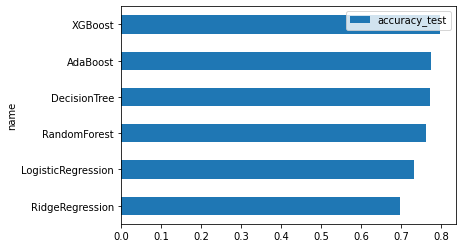

In [19]:
df_scores.sort_values("accuracy_test", ascending = True).plot(kind= "barh", x= "name", y = "accuracy_test")

## XGBoost

In [36]:
param_grid_xgb = {
    'n_estimators': list(range(2,52)),
    'max_depth': [None] + list(range(3,15)),
    "learning_rate": np.linspace(0.0001, 1).astype(float),
    'booster': ["gbtree", "gblinear", "dart"]}

# Instantiate random search and define the metric to optimize 
rs_xgb = RandomizedSearchCV(xgb.XGBClassifier(), param_grid_xgb, scoring='accuracy',
                  cv=5, verbose=5, n_jobs=-1, n_iter=30)

# Fit randomized search object to data
rs_xgb.fit(X_train_prep, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[13:02:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100,...
       7.34720408e-01, 7.55126531e-01, 7.75532653e-01, 7.95938776e-01,
       8.16344898e-01, 8.36751020e-01, 8.57157143e-01, 8.77563265e-01,
       8.97969388e-01, 9.18375510e-01, 

In [37]:
rs_xgb.best_params_

{'n_estimators': 25,
 'max_depth': 7,
 'learning_rate': 0.34700408163265306,
 'booster': 'gbtree'}

In [38]:
param_grid_xgb = {
    'n_estimators': np.linspace(20, 100).astype(int),
    'max_depth': [None] + list(np.linspace(3, 10).astype(int)),
    "learning_rate": np.linspace(0.0001, 1).astype(float),
    'booster': ["gbtree", "gblinear", "dart"]}

grid_xgb = GridSearchCV(pipe_logreg, param_grid=param_logreg, cv=5, scoring='accuracy', 
                           verbose=5, n_jobs=-1)

NameError: name 'param_logreg' is not defined

In [40]:
best_xgb = rs_xgb.best_estimator_

y_train_pred = best_xgb.predict(X_train_prep)
y_pred = best_xgb.predict(X_test_prep)

In [41]:
print_scores(y_train, y_train_pred)
print_scores(y_test, y_pred)

Cross validation scores:
-------------------------
Accuracy: 0.80
Recall: 0.86
Precision: 0.83

Confusion matrix:
-------------------------
[[40964 16101]
 [12779 77446]]
Cross validation scores:
-------------------------
Accuracy: 0.79
Recall: 0.85
Precision: 0.82

Confusion matrix:
-------------------------
[[10123  4182]
 [ 3457 19061]]


In [ ]:
model_name.append("XGBoost optimized")

accuracy.append(accuracy_score(y_train, y_train_pred))
recall.append(recall_score(y_train, y_train_pred))
precision.append(precision_score(y_train, y_train_pred))
    
accuracy_test.append(accuracy_score(y_test, y_pred))
recall_test.append(recall_score(y_test, y_pred))
precision_test.append(precision_score(y_test, y_pred))

## AdaBoost

In [ ]:
param_grid_ada = {
    'n_estimators': np.linspace(10, 200).astype(int),
    'max_depth': [None] + list(np.linspace(3, 20).astype(int)),
    "learning_rate": np.linspace(0.0001, 1).astype(float),
    'booster': ["gbtree", "gblinear", "dart"]}

# Instantiate random search and define the metric to optimize 
rs_ada = RandomizedSearchCV(AdaBoostClassifier(random_state=RSEED), param_grid_ada, scoring='accuracy',
                  cv=5, verbose=5, n_jobs=-1, n_iter=10)

# Fit randomized search object to data
rs_ada.fit(X_train_prep, y_train)

In [ ]:
best_ada = rs_ada.best_estimator_

y_train_pred = best_ada.predict(X_train_prep)
y_pred = best_ada.predict(X_test_prep)

In [ ]:
model_name.append("XGBoost optimized")

accuracy.append(accuracy_score(y_train, y_train_pred))
recall.append(recall_score(y_train, y_train_pred))
precision.append(precision_score(y_train, y_train_pred))
    
accuracy_test.append(accuracy_score(y_test, y_pred))
recall_test.append(recall_score(y_test, y_pred))
precision_test.append(precision_score(y_test, y_pred))

In [ ]:
print_scores(y_train, y_train_pred)
print_scores(y_test, y_pred)